In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_json("/content/user-wallet-transactions.json")

x=df.head(1)

In [34]:
# HERE I Analyse the dataset by checking each features
# df.iloc[:,2].unique()
# x.iloc[:,4].values
print("Columns of our data:")
print(df.columns.tolist())

Columns of our data:
['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt', 'updatedAt']


After analysing the data these are the insights

**Action**: Deposit, Borrow, Repay, etc.

**Timestamp**: When it happened

**Asset**: Which coin (WETH, DAI, etc.)

**Amount**: How much crypto

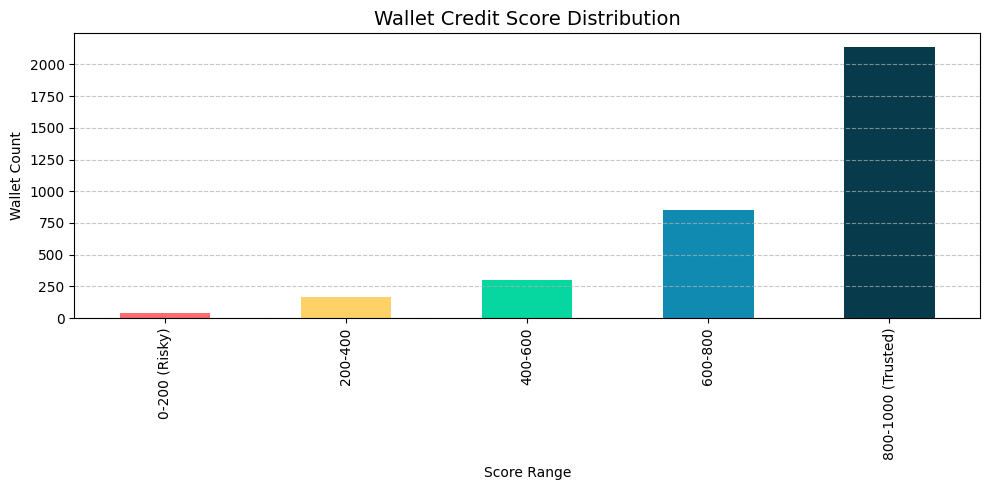

/tmp/ipython-input-49-4250780113.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = wallets.groupby('score_group')[['repay_ratio', 'was_liquidated', 'days_active', 'borrows']].mean()


In [49]:
from sklearn.ensemble import IsolationForest

# Load and preprocess data
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df['tx_type'] = df['action']
df['asset'] = df['actionData'].apply(lambda x: x.get('assetSymbol', 'Unknown'))

# Create wallet-level aggregated features
wallets = df.groupby('userWallet').agg(
    total_txs=('tx_type', 'count'),
    deposits=('tx_type', lambda x: (x == 'deposit').sum()),
    borrows=('tx_type', lambda x: (x == 'borrow').sum()),
    repays=('tx_type', lambda x: (x == 'repay').sum()),
    liquidations=('tx_type', lambda x: (x == 'liquidationcall').sum()),
    first_tx=('date', 'min'),
    last_tx=('date', 'max'),
    unique_assets=('asset', 'nunique')
).reset_index()

# Time-based features
now = df['date'].max()
wallets['days_active'] = (wallets['last_tx'] - wallets['first_tx']).dt.days
wallets['days_since_active'] = (now - wallets['last_tx']).dt.days
wallets['repay_ratio'] = wallets['repays'] / wallets['borrows'].replace(0, np.nan)
wallets['repay_ratio'] = wallets['repay_ratio'].fillna(0)  # handle 0 borrows safely
wallets['was_liquidated'] = (wallets['liquidations'] > 0).astype(int)

# Select features for scoring
features = wallets[['borrows', 'repays', 'repay_ratio', 'was_liquidated', 'days_active', 'unique_assets']]

# Isolation Forest credit scoring
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(features)
scores = model.decision_function(features)
wallets['credit_score'] = 1000 * (scores - scores.min()) / (scores.max() - scores.min())

# Save credit scores
wallets[['userWallet', 'credit_score']].to_csv('wallet_scores.csv', index=False)

# Score buckets
bins = [0, 200, 400, 600, 800, 1000]
labels = ['0-200 (Risky)', '200-400', '400-600', '600-800', '800-1000 (Trusted)']
wallets['score_group'] = pd.cut(wallets['credit_score'], bins=bins, labels=labels)

# Plot score distribution
plt.figure(figsize=(10, 5))
wallets['score_group'].value_counts().sort_index().plot(
    kind='bar', color=['#ff6b6b', '#ffd166', '#06d6a0', '#118ab2', '#073b4c'])
plt.title('Wallet Credit Score Distribution', fontsize=14)
plt.xlabel('Score Range')
plt.ylabel('Wallet Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('score_distribution.png')
plt.show()

# Print group-level behavior insights
summary = wallets.groupby('score_group')[['repay_ratio', 'was_liquidated', 'days_active', 'borrows']].mean()
summary = summary.rename(columns={
    'repay_ratio': 'Avg Repay Ratio',
    'was_liquidated': '% Liquidated',
    'days_active': 'Avg Active Days',
    'borrows': 'Avg Borrows'
})



In [50]:
print(" Credit Score Group Summary:")
print(summary.round(2))

 Credit Score Group Summary:
                    Avg Repay Ratio  % Liquidated  Avg Active Days  \
score_group                                                          
0-200 (Risky)                  3.42          0.39            90.88   
200-400                        1.20          0.52            68.75   
400-600                        0.95          0.00            65.03   
600-800                        0.61          0.00            40.00   
800-1000 (Trusted)             0.05          0.00             3.18   

                    Avg Borrows  
score_group                      
0-200 (Risky)             82.29  
200-400                   26.54  
400-600                   17.36  
600-800                    4.15  
800-1000 (Trusted)         0.22  
